In [65]:
import pandas as pd
import numpy as np
import math
import category_encoders as ce
import re
import unidecode
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

# Wczytanie danych
Zgodnie z zaleceniami ustawiam kolumne price jako target

In [66]:
data = pd.read_csv("./allegro-api-transactions.csv")
data.it_location = data.it_location.apply(unidecode.unidecode)
data.it_location = data.it_location.str.lower() #Zamiana na małe litery
def collapse(col):
    col = re.sub(r"\s+", "",col, flags=re.UNICODE)
    return col

data.it_location = data.it_location.apply(collapse) #Kasoawnie wszystkich spacji, daje to spadek unikalnych wartosci o prawie 5 tysiecy

y = data.price
data_with_y = data.copy()

data.drop(['price','lp','item_id'],axis=1,inplace=True)

Wszystkie nazwy miast zamieniłem na małe litery, pozbyłem sie polskich znaków oraz spacji, co pozwoliło pozbyć się prawie 3 tysięcy unikalnych poziomów, dzięki czemu łatwiej będzie na tym operować.

In [67]:
data.isna().sum().sum()

0

Brak nulli

In [68]:
data.nunique()

date                      38953
categories                 9020
pay_option_on_delivery        2
pay_option_transfer           2
seller                    51064
it_is_allegro_standard        2
it_quantity                7305
it_is_brand_zone              2
it_seller_rating          46093
it_location                7018
main_category                27
dtype: int64

# Kodowanie danych

In [69]:
target_encoder = ce.TargetEncoder(cols='it_location',smoothing=2)
target_encoder.fit(data,y)
data_transformed_target = target_encoder.transform(data)
data_transformed_target

,date,categories,pay_option_on_delivery,pay_option_transfer,seller,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,main_category
0,2016-04-03 21:21:08,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,1,997,0,50177,84.128595,Komputery
1,2016-04-03 15:35:26,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,1,9288,0,12428,84.128595,"Odzież, Obuwie, Dodatki"
2,2016-04-03 14:14:31,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,1,895,0,7389,65.180279,Dom i Ogród
3,2016-04-03 19:55:44,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,0,971,0,15006,35.433365,Książki i Komiksy
4,2016-04-03 18:05:54,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,1,950,0,32975,71.289049,"Odzież, Obuwie, Dodatki"
...,...,...,...,...,...,...,...,...,...,...,...
420015,2016-04-03 20:27:13,"['RTV i AGD', 'Sprzęt audio dla domu', 'Odtwar...",0,0,iwona7012,0,0,0,176,26.555918,RTV i AGD
420016,2016-04-03 22:35:02,"['Uroda', 'Makijaż', 'Oczy', 'Tusze do rzęs']",1,1,Dolce_Cosmetics,1,2,0,34851,66.082877,Uroda
420017,2016-04-03 22:38:57,"['Odzież, Obuwie, Dodatki', 'Przebrania, kosti...",1,1,pewex4all,1,470,0,983,18.683157,"Odzież, Obuwie, Dodatki"
420018,2016-04-03 22:44:17,"['Dla Dzieci', 'Rowery i pojazdy', 'Rowery bie...",1,0,kostasia,0,0,0,163,102.848875,Dla Dzieci


In [70]:
data_transformed_target.it_location

0          84.128595
1          84.128595
2          65.180279
3          35.433365
4          71.289049
             ...    
420015     26.555918
420016     66.082877
420017     18.683157
420018    102.848875
420019     78.136792
Name: it_location, Length: 420020, dtype: float64

Target Encoder ładnie zakodował wszystkie miasta, co niestety nie było możliwe dla One Hot Encodingu, gdyż mój komputer nie był w stanie zaalkować tak dużo pamięci jak wymaga tego ta forma kodowania. Od razu widać iż jest to główna zaleta Target Encodera, tzn. opereacje przez niego wykonywne aby zakodować dane wymagają niewiele pamięci, gdzie OneHotEnocder alokuje tej pamięci bardzo dużo, co często utrudnia prace z tymi danymi.

In [71]:
data = data_transformed_target.copy()


In [72]:
data1 = data.copy()
y1 =y.copy()
one_hot_encoder = ce.OneHotEncoder(cols='main_category')
one_hot_encoder.fit(data1,y1)
data_one_hot = one_hot_encoder.transform(data1)
data_one_hot.head()

,date,categories,pay_option_on_delivery,pay_option_transfer,seller,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,it_location,...,main_category_18,main_category_19,main_category_20,main_category_21,main_category_22,main_category_23,main_category_24,main_category_25,main_category_26,main_category_27
0,2016-04-03 21:21:08,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,1,997,0,50177,84.128595,...,0,0,0,0,0,0,0,0,0,0
1,2016-04-03 15:35:26,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,1,9288,0,12428,84.128595,...,0,0,0,0,0,0,0,0,0,0
2,2016-04-03 14:14:31,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,1,895,0,7389,65.180279,...,0,0,0,0,0,0,0,0,0,0
3,2016-04-03 19:55:44,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,0,971,0,15006,35.433365,...,0,0,0,0,0,0,0,0,0,0
4,2016-04-03 18:05:54,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,1,950,0,32975,71.289049,...,0,0,0,0,0,0,0,0,0,0


In [73]:
data2 = data.copy()
y2 = y.copy()
cat_boost_encoder = ce.CatBoostEncoder(cols='main_category')
perm = np.random.permutation(len(data2)) #Losowo permutuje wiersze (jest to zalecane w dokumentacji tej funkcji)
data2 = data2.iloc[perm].reset_index(drop=True) 
y2 = y2.iloc[perm].reset_index(drop=True)
cat_boost_encoder.fit(data2,y2)
data_cat_boost = cat_boost_encoder.transform(data2)
data_cat_boost.main_category.head()

0    75.858066
1    71.206519
2    72.434802
3    25.031971
4    81.363313
Name: main_category, dtype: float64

In [74]:
data3 = data.copy()
y3 = y.copy()
polynomial_encoder = ce.PolynomialEncoder(cols='main_category')
polynomial_encoder.fit(data3,y3)
data_polynomial = polynomial_encoder.transform(data3)
data_polynomial.head()

,intercept,date,categories,pay_option_on_delivery,pay_option_transfer,seller,it_is_allegro_standard,it_quantity,it_is_brand_zone,it_seller_rating,...,main_category_16,main_category_17,main_category_18,main_category_19,main_category_20,main_category_21,main_category_22,main_category_23,main_category_24,main_category_25
0,1,2016-04-03 21:21:08,"['Komputery', 'Dyski i napędy', 'Nośniki', 'No...",1,1,radzioch666,1,997,0,50177,...,-0.002429,0.001117,-0.000478,0.000189,-0.000069,0.000022,-0.000006,0.000002,-3.206860e-07,4.490498e-08
1,1,2016-04-03 15:35:26,"['Odzież, Obuwie, Dodatki', 'Bielizna damska',...",1,1,InwestycjeNET,1,9288,0,12428,...,0.026161,-0.013576,0.006512,-0.002868,0.001149,-0.000413,0.000131,-0.000035,7.696464e-06,-1.167529e-06
2,1,2016-04-03 14:14:31,"['Dom i Ogród', 'Budownictwo i Akcesoria', 'Śc...",1,1,otostyl_com,1,895,0,7389,...,-0.119078,0.071643,-0.039341,0.019631,-0.008835,0.003543,-0.001243,0.000370,-8.818865e-05,1.459412e-05
3,1,2016-04-03 19:55:44,"['Książki i Komiksy', 'Poradniki i albumy', 'Z...",1,1,Matfel1,0,971,0,15006,...,0.286143,-0.209481,0.136451,-0.079261,0.040921,-0.018611,0.007334,-0.002432,6.413720e-04,-1.167530e-04
4,1,2016-04-03 18:05:54,"['Odzież, Obuwie, Dodatki', 'Ślub i wesele', '...",1,1,PPHU_RICO,1,950,0,32975,...,0.026161,-0.013576,0.006512,-0.002868,0.001149,-0.000413,0.000131,-0.000035,7.696464e-06,-1.167529e-06


Efekty encoderów widać na ramkach powyżej. Oprócz wymaganego One Hot Encodera, zdecydowałem się użyc Cat Boost Encodera oraz Polynomial Encodera. O ile wynik zwrócony przez One Hot jest oczywisty, to działanie dwóch pozostałych jest już znacznie bardziej skomplikowane. Z tego co znalazłem, to CatBoost swoim działaniem może trochę przypominać Target Encodera, widać też że wyniki przez niego zwrócone są podobnego typu, co te zwrócone przez faktycznego Target Encodera, którego używam parę chunków wyżej. Z kolei wyniki zwrócone przez Polynomial Encodera przypominają odrobinę to co zwrócil One Hot (głównie dzieki podobnemu utworzeniu takiej ilości nowych kolumn ile jest unikalnych poziomów danych w kolumnie), jednakże wartości w tych kolumnach są juz różne od {0,1}, a dokładniej to należą one do przedziału [-1,1], gdzie faktyczne wartości są wyliczane przez sam algortym kodowania.

# Zmienne numeryczne 

In [75]:
data = data_with_y
data = data[['price','it_seller_rating','it_quantity']]

Najpierw usuwam dane z jednej kolumny i sprawdzam i powtarzam imputacje 30 krotnie, aby uzyskać wiarygodniejsze dane.

In [76]:
scores = []
for i in range(30):
    data0 = data.copy()
    data0 = data0[['price','it_seller_rating','it_quantity']]
    piece = np.random.randint(data0.shape[0],size=math.ceil(0.1*data0.shape[0]))
    data0.it_seller_rating.loc[piece] = np.nan
    imp = IterativeImputer(max_iter=20)
    data_multi_imp = pd.DataFrame(imp.fit_transform(data0))
    scores.append(mean_squared_error(data_multi_imp,data,squared=False))
print(f'Std ={np.std(scores)}, mean={np.mean(scores)}')

Std =62.031048732933534, mean=6534.6077222963


Powtarzam działanie dla drugiej kolumny.

In [77]:
scores0 = []
for i in range(30):
    data1 = data.copy()
    data1 = data1[['price','it_seller_rating','it_quantity']]
    piece = np.random.randint(data1.shape[0],size=math.ceil(0.1*data1.shape[0]))
    data1.it_quantity.loc[piece] = np.nan
    imp = IterativeImputer(max_iter=20)
    data_multi_imp = pd.DataFrame(imp.fit_transform(data1))
    scores0.append(mean_squared_error(data_multi_imp,data,squared=False))
print(f'Std ={np.std(scores0)}, mean={np.mean(scores0)}')

Std =26.073168187983352, mean=4166.191031683632


A teraz dla obu kolumn

In [78]:
scores1 = []
for i in range(30):
    data2 = data.copy()
    data2 = data2[['price','it_seller_rating','it_quantity']]
    piece = np.random.randint(data2.shape[0],size=math.ceil(0.1*data2.shape[0]))
    piece1 = np.random.randint(data2.shape[0],size=math.ceil(0.1*data2.shape[0]))
    data2.it_seller_rating.loc[piece] = np.nan
    data2.it_quantity.loc[piece] = np.nan
    imp = IterativeImputer(max_iter=20)
    data_multi_imp = pd.DataFrame(imp.fit_transform(data2))
    scores1.append(mean_squared_error(data_multi_imp,data,squared=False))
print(f'Std ={np.std(scores1)}, mean={np.mean(scores1)}')
len(scores0)
len(scores1)

Std =56.21558097072661, mean=7757.396106575427


30

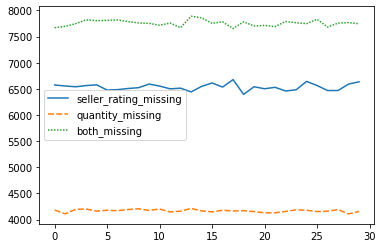

In [79]:
scor = pd.DataFrame({"seller_rating_missing":scores,"quantity_missing":scores0,"both_missing":scores1})
sns.lineplot(data= scor)


Zgodnie z tym co się dało przewidzieć bład przy usuwaniu danych w dwóch kolumnach był większy niż przy usuwaniu w jednej, aczkolwiek co interesujące różnica pomiędzy usuwaniem w kolumnie quantity a columnie seller_rating jest dość znacząco różna. Widać również że usuwanie danych w obydwu skutkuje największym błędem, czego można się było spodziewać.